In [30]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn import set_config

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchmetrics import Accuracy
from torch.utils.data import Dataset, DataLoader

In [31]:
df=pd.read_csv('/kaggle/input/byjus-data-clean/Byjus.csv')

In [32]:
def convert_age(X):
    X = X.copy()
    X['age'] = pd.to_numeric(X['age'].astype(str).str.replace('+', '', regex=False), errors='coerce')
    X['age'] = pd.cut(X['age'], 
                      bins=[18, 22, 25, 28, 32, 35, float('inf')],
                      labels=['18-22', '23-25', '26-28', '29-32', '33-35', '35+'], 
                      right=True)
    return X

In [33]:
# Education mapping
education_mapping = {
    'engineering & technology': ['b.e / b-tech', 'bca/mca','m.e / m-tech', 'b.voc in networking and mobile applications', 
                                 'b.arch', 'b.eng', 'b-tech', 'cse', 'bsc bedd - computer science', 
                                 'bachelors in engineering','food technology', 'biotechnology', 'masters in data science', 'btech', 'mca'],
    'bsc/msc': ['bsc', 'bsc or msc', 'bachelors in philosophy'],
    'commerce & business': ['mba', 'b.com (bachelor of commerce)', 'b.com', 'b.comm', 'bba', 'bbm', 'bms', 
                            'bachelor of business economics', 'bcom computers','bms marketing', 'pgdm banking', 
                            'bcom', 'bba or bbm', 'master in management'],
    'arts & humanities': ['ba', 'ba/ma', 'ma', 'bachelor mass communication', 'bachelors in design', 
                          'bachelor of social work', 'bachelor in eco'],
    'healthcare & medicine': ['b.pharma', 'med', 'bpharma', 'bds', 'b.physiotherapist', 'mbbs', 'pharma d', 
                              'b -pharm', 'bachelor in medical lab', 'bachelor in dental'],
    'social sciences': ['masters in social work', 'msw', 'masters in clinical psychology', 'masters in social science', 'masters in sociology'],
    'diplomas & certifications': ['pgdm', 'pgdca', 'diploma', 'post graduation diploma', 'pgdf'],
    'phd & doctorate': ['phd', 'doctorate',  'm.phil  2020'],
    'vocational/technical': ['b.voc', 'vocational', 'bachelor of vocational','b voc - banking & finance'],
    'hospitality & tourism': ['hotel management', 'masters in hospitality', 'tourism']
}

#Function to categorize education into broader categories
def edu_function(degree):
    degree = str(degree).lower()
    for category, keywords in education_mapping.items():
        for keyword in keywords:
            if keyword.lower() in degree:
                return category
    return 'Other'

def categorize_degree(X):
    X = X.copy()
    X['Education'] = X['Education'].str.lower().fillna('Other')
    X['Education'] = X['Education'].apply(edu_function)
    return X

In [34]:
def label_encoder(X):
    X = X.copy()
    label_encoders = {}
    categorical_cols = ['gender', 'marital_status', 'interview_mode', 
                        'mother_tongue_influence_in_english',
                        'Anyone_spoken_before_applying', 
                        'currently_employed',
                        'candidate_status']

    for col in categorical_cols:
        X[col] = X[col].fillna('Unknown')
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col])
        label_encoders[col] = le
    return X

In [35]:
df['interview_verdict'] = df['interview_verdict'].replace({'Premium Select': 'Select', 'Borderline Select': 'Select', 'Borderline Reject': 'Reject'})

In [36]:
# Label encode the target
le_verdict = LabelEncoder()
df['interview_verdict'] = le_verdict.fit_transform(df['interview_verdict'])


In [37]:
numerical_cols = ['confidence_based_on_introduction_(english)',
                  'confidence_based_on_the_topic_given__',
                  'confidence_based_on_the_ppt_question',
                  'confidence_based_on_the_sales_scenario',
                  'structured_thinking_(in_regional_only)',
                  'structured_thinking_based_on_the_ppt_question',
                  'structured_thinking(_call_pitch)',
                  'regional_fluency_based_on_the_topic_given__',
                  'regional_fluency_based_on_the_ppt_question',
                  'regional_fluency_based_on_the__sales_scenario',
                  'confidence_score',
                  'structured_thinking_score',
                  'regional_fluency_score',
                  'total_score'
                 ]

categorical_cols = ['Education',
                    'gender',
                    'marital_status',
                    'interview_mode',
                    'mother_tongue_influence_in_english',
                    'Anyone_spoken_before_applying',
                    'currently_employed',
                    'candidate_status', 
                    'candidate_is_willing_to_relocate',
                    'last_fixed_ctc_(lakhs)', 
                    'experience_in_months',
                    'what_was_the_type_of_role?',
                    'how_many_slides_candidate_have_submitted_in_ppt?', 
                    'role_acceptance', 
                    'age']

preprocessing_pipeline = Pipeline([('convert_age', FunctionTransformer(convert_age, validate=False)),
                                   ('categorize_education', FunctionTransformer(categorize_degree, validate=False)),
                                   ('label_encoder', FunctionTransformer(label_encoder, validate=False)),
                                   ('encode_scale', ColumnTransformer(transformers=[
                                       ('onehot', OneHotEncoder(sparse_output=False, drop='first'), categorical_cols),        #  One-hot encode categorical features
                                       ('scaler', StandardScaler(), numerical_cols)                                           #  StandardScaler for all numerical columns
                                   ], remainder='passthrough'))
                                  ])

In [38]:
# Display the pipeline diagram
from sklearn import set_config
set_config(display='diagram')
preprocessing_pipeline

Pipeline(steps=[('convert_age',
                 FunctionTransformer(func=<function convert_age at 0x7ad8d170b880>)),
                ('categorize_education',
                 FunctionTransformer(func=<function categorize_degree at 0x7ad8d1c45000>)),
                ('label_encoder',
                 FunctionTransformer(func=<function label_encoder at 0x7ad98847a9e0>)),
                ('encode_scale',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('o...
                                                   'structured_thinking_(in_regional_only)',
                                                   'structured_thinking_based_on_the_ppt_question',
                                                   'structured_thinking(_call_pitch)',
                                                   'regional_fluency_based_on_the_topic_given__',
                                                   'regional_fluency_based_on_the_ppt_question',
                                                   'regional_fluency_based_on_the__sales_scenario',
                                                   'confidence_score',
                                                   'structured_thinking_score',
                                                   'regional_fluency_score',
                                                   'total_score'])]))])

In [39]:
# Splitting the data
X = df.drop(columns=['interview_verdict']).copy()
y = df['interview_verdict']

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [41]:
preprocessing_pipeline.fit(X_train, y_train)

Pipeline(steps=[('convert_age',
                 FunctionTransformer(func=<function convert_age at 0x7ad8d170b880>)),
                ('categorize_education',
                 FunctionTransformer(func=<function categorize_degree at 0x7ad8d1c45000>)),
                ('label_encoder',
                 FunctionTransformer(func=<function label_encoder at 0x7ad98847a9e0>)),
                ('encode_scale',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('o...
                                                   'structured_thinking_(in_regional_only)',
                                                   'structured_thinking_based_on_the_ppt_question',
                                                   'structured_thinking(_call_pitch)',
                                                   'regional_fluency_based_on_the_topic_given__',
                                                   'regional_fluency_based_on_the_ppt_question',
                                                   'regional_fluency_based_on_the__sales_scenario',
                                                   'confidence_score',
                                                   'structured_thinking_score',
                                                   'regional_fluency_score',
                                                   'total_score'])]))])

In [42]:
# Fit and transform with pipeline
X_train_processed = preprocessing_pipeline.fit_transform(X_train, y_train)
X_test_processed = preprocessing_pipeline.transform(X_test)

# ****Working on Pytorch

In [43]:
# Convert to NumPy array and float32
y_train_array = np.array(y_train).astype(np.float32)
y_test_array = np.array(y_test).astype(np.float32)

# Convert the preprocessed data into PyTorch tensors
X_train_tensor = torch.tensor(X_train_processed, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_processed, dtype=torch.float32)

# Convert the target variables into PyTorch tensors
y_train_tensor = torch.tensor(y_train_array, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_array, dtype=torch.float32)

In [44]:
# Confirm the shapes
print(f"X_train_tensor shape: {X_train_tensor.shape}, y_train_tensor shape: {y_train_tensor.shape}")
print(f"X_test_tensor shape: {X_test_tensor.shape}, y_test_tensor shape: {y_test_tensor.shape}")


X_train_tensor shape: torch.Size([14808, 64]), y_train_tensor shape: torch.Size([14808])
X_test_tensor shape: torch.Size([3702, 64]), y_test_tensor shape: torch.Size([3702])


In [45]:
# # Custom Dataset Class
# class CandidateDataset(Dataset):
#     def __init__(self, X, y):
#         """
#         Args:
#         - X: Input features (Tensor)
#         - y: Target labels (Tensor)
#         """
#         self.X = X
#         self.y = y

#     def __len__(self):
#         return len(self.X)

#     def __getitem__(self, idx):
#         return self.X[idx], self.y[idx].unsqueeze(0)

In [46]:
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [47]:
from torch.utils.data import DataLoader

# Create dataset instances
train_dataset = CustomDataset(X_train_tensor, y_train_tensor)
test_dataset = CustomDataset(X_test_tensor, y_test_tensor)

# Define DataLoader
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [48]:
import torch.nn as nn

# Model definition
class CandidateRankingModel(nn.Module):
    def __init__(self, input_dim):
        super(CandidateRankingModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(0.3)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.relu(self.bn2(self.fc2(x)))
        x = torch.sigmoid(self.fc3(x))  # Sigmoid activation for binary classification
        return x

In [49]:
# Instantiate the model
input_dim = X_train_tensor.shape[1]
model = CandidateRankingModel(input_dim)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [50]:
# Check if model and data pipeline are working correctly
model.train()
for batch_X, batch_y in train_loader:
    batch_X, batch_y = batch_X.to(device), batch_y.to(device)
    
    # Forward pass
    outputs = model(batch_X)
    print("Batch shape:", batch_X.shape)
    print("Output shape:", outputs.shape)
    print("Sample output:", outputs[:5])
    
    break  # Exit after one batch

Batch shape: torch.Size([64, 64])
Output shape: torch.Size([64, 1])
Sample output: tensor([[0.4694],
        [0.6001],
        [0.6267],
        [0.3422],
        [0.5222]], device='cuda:0', grad_fn=<SliceBackward0>)


In [51]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import time

def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    all_labels = []
    all_preds = []

    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        optimizer.zero_grad()
        outputs = model(batch_X)

        # Reshape target to match the output shape
        batch_y = batch_y.view(-1, 1)

        # Compute loss
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Store predictions and labels for metrics calculation
        preds = (outputs >= 0.5).float()  # Threshold at 0.5 for binary classification
        all_preds.extend(preds.cpu().detach().numpy())
        all_labels.extend(batch_y.cpu().detach().numpy())

    avg_loss = running_loss / len(train_loader)

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    auc_roc = roc_auc_score(all_labels, all_preds)

    return avg_loss, accuracy, precision, recall, f1, auc_roc


In [52]:
def evaluate(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            outputs = model(batch_X)

            # Reshape target to match the output shape
            batch_y = batch_y.view(-1, 1)

            loss = criterion(outputs, batch_y)
            running_loss += loss.item()

            preds = (outputs >= 0.5).float()
            all_preds.extend(preds.cpu().detach().numpy())
            all_labels.extend(batch_y.cpu().detach().numpy())

    avg_loss = running_loss / len(test_loader)

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    auc_roc = roc_auc_score(all_labels, all_preds)

    return avg_loss, accuracy, precision, recall, f1, auc_roc


In [53]:
import matplotlib.pyplot as plt

# Hyperparameters
epochs = 20
train_losses, test_losses = [], []
train_acc, test_acc = [], []
train_prec, test_prec = [], []
train_recall, test_recall = [], []
train_f1, test_f1 = [], []
train_auc, test_auc = [], []

start_time = time.time()

for epoch in range(1, epochs + 1):
    # Train the model
    train_loss, train_accuracy, train_precision, train_recall, train_f1_score, train_auc_roc = train(
        model, train_loader, criterion, optimizer, device
    )
    
    # Evaluate on the test set
    test_loss, test_accuracy, test_precision, test_recall, test_f1_score, test_auc_roc = evaluate(
        model, test_loader, criterion, device
    )

    # Store metrics
    train_losses.append(train_loss)
    test_losses.append(test_loss)

    train_acc.append(train_accuracy)
    test_acc.append(test_accuracy)

    train_prec.append(train_precision)
    test_prec.append(test_precision)

    train_recall.append(train_recall)
    test_recall.append(test_recall)

    train_f1.append(train_f1_score)
    test_f1.append(test_f1_score)

    train_auc.append(train_auc_roc)
    test_auc.append(test_auc_roc)

    # Print epoch results
    print(f"\nEpoch {epoch}/{epochs}")
    print(f"Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f}")
    print(f"Train Acc: {train_accuracy:.4f} | Test Acc: {test_accuracy:.4f}")
    print(f"Train Precision: {train_precision:.4f} | Test Precision: {test_precision:.4f}")
    print(f"Train Recall: {train_recall:.4f} | Test Recall: {test_recall:.4f}")
    print(f"Train F1 Score: {train_f1_score:.4f} | Test F1 Score: {test_f1_score:.4f}")
    print(f"Train AUC-ROC: {train_auc_roc:.4f} | Test AUC-ROC: {test_auc_roc:.4f}")

end_time = time.time()
print(f"\nTraining completed in {end_time - start_time:.2f} seconds.")



Epoch 1/20
Train Loss: 0.3747 | Test Loss: 0.3055
Train Acc: 0.8394 | Test Acc: 0.8744

Epoch 2/20
Train Loss: 0.3148 | Test Loss: 0.2944
Train Acc: 0.8678 | Test Acc: 0.8801

Epoch 3/20
Train Loss: 0.3029 | Test Loss: 0.2879
Train Acc: 0.8747 | Test Acc: 0.8844

Epoch 4/20
Train Loss: 0.2965 | Test Loss: 0.2909
Train Acc: 0.8766 | Test Acc: 0.8830

Epoch 5/20
Train Loss: 0.2944 | Test Loss: 0.2908
Train Acc: 0.8788 | Test Acc: 0.8817

Epoch 6/20
Train Loss: 0.2892 | Test Loss: 0.2898
Train Acc: 0.8813 | Test Acc: 0.8830

Epoch 7/20
Train Loss: 0.2863 | Test Loss: 0.2879
Train Acc: 0.8813 | Test Acc: 0.8820

Epoch 8/20
Train Loss: 0.2838 | Test Loss: 0.2891
Train Acc: 0.8819 | Test Acc: 0.8833

Epoch 9/20
Train Loss: 0.2822 | Test Loss: 0.2887
Train Acc: 0.8845 | Test Acc: 0.8822

Epoch 10/20
Train Loss: 0.2811 | Test Loss: 0.2878
Train Acc: 0.8838 | Test Acc: 0.8855

Epoch 11/20
Train Loss: 0.2795 | Test Loss: 0.2882
Train Acc: 0.8855 | Test Acc: 0.8798

Epoch 12/20
Train Loss: 0.276

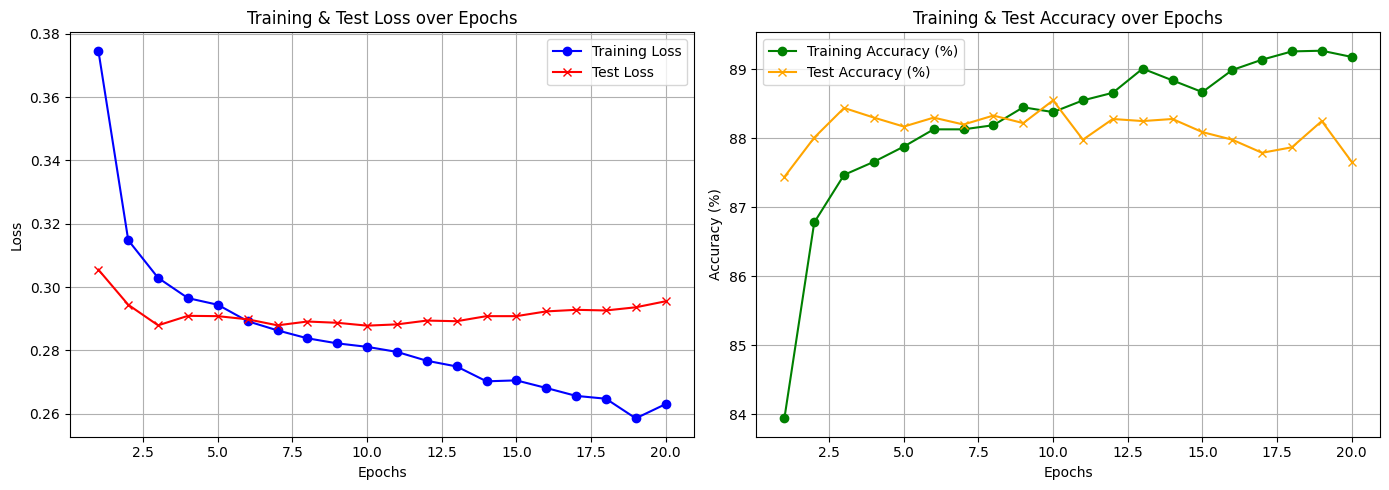

In [58]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
axes[0].plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss', color='blue', marker='o')
axes[0].plot(range(1, len(test_losses) + 1), test_losses, label='Test Loss', color='red', marker='x')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training & Test Loss over Epochs')
axes[0].legend()
axes[0].grid(True)

# Accuracy plot
axes[1].plot(range(1, len(train_acc) + 1), [acc for acc in train_acc], label='Training Accuracy (%)', color='green', marker='o')
axes[1].plot(range(1, len(test_acc) + 1), [acc for acc in test_acc], label='Test Accuracy (%)', color='orange', marker='x')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Training & Test Accuracy over Epochs')
axes[1].legend()
axes[1].grid(True)

# Display the plots
plt.tight_layout()
plt.show()


In [59]:
import os
import torch

# ✅ Kaggle working directory
base_dir = '/kaggle/working/Model/Models_Parameters'
os.makedirs(base_dir, exist_ok=True)  # Create directories if they don't exist

# ✅ Save the model parameters properly
model_path = f"{base_dir}/Candidate_Recommender_model.pth"
torch.save(model.state_dict(), model_path)  # Save model parameters
print(f"Model parameters saved at: {model_path}")


Model parameters saved at: /kaggle/working/Model/Models_Parameters/Candidate_Recommender_model.pth
